# 2. Conv3D

![conv3d](https://miro.medium.com/max/1400/0*J4N59yfFVKY5K8fa.png)

In the second sample submission, we will look at how we can use a simple implementation of Conv3D to increase the prediction accuracy of the initial example model. To keep things simple, we are going to use the same 'infrastracture' as in the initial climate-hack submission folder and instead, we are going to implement a few changes in the ```model.py``` script.

## Theory

Fundamentally, 3D CNN is quite similar to the regular, 2D CNN expect a few differences.

The original 2D CNN performs its multiplication between the input and the filters using 2D matrices. In 3D CNN, we simply perform these operations on multiple pairs of 2D matrices.

The second difference appears in the **MaxPooling** layer. In the regular 2D CNN we were taking applying a small 2x2 filter to reduce our initial input. Consequently, in 3D CNN, we are going to apply 2x2x2 cube to the cube input (in such example case, 4x4x4).

The reason why 3D CNN can be applied to our problem is that the additional dimension allows to take into the spatiotemporal differences in our dataset. In simple terms, 3D CNN allows us to consider the x and y changes **in addition to** time.

### Importing modules

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from numpy import float32
from torch.utils.data import DataLoader
from torchsummary import summary

from dataset import ClimateHackDataset
from loss import MS_SSIMLoss
from submission.model import Model

plt.rcParams["figure.figsize"] = (20, 12)

### Loading the dataset

The 108GB HRV ("high resolution visible") satellite imagery dataset may be loaded directly from Google Cloud Public Datasets using `xarray`, `zarr`, `gcsfs` and `dask`. Alternatively a local copy can be downloaded and loaded instead for better performance. The pixel values represent calibrated top-of-atmosphere bidirectional irradiance values mapped to the range `[0, 1023]`. Read more about the data on the [Google Cloud Platform](https://console.cloud.google.com/marketplace/product/bigquery-public-data/eumetsat-seviri-rss-hrv-uk).

Since the dataset is so large, we have provided a `ClimateHackDataset` class in `dataset.py` that selects a sliding window of twelve 128x128 images (taken five minutes apart, corresponding to an hour of data) for randomly sampled areas roughly over the mainland UK to use in training.

In [2]:
SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)


BATCH_SIZE = 10
EPOCHS = 50

ch_dataset = ClimateHackDataset(dataset, crops_per_slice=1, day_limit=7)
ch_dataloader = DataLoader(ch_dataset, batch_size=BATCH_SIZE)

### Creating model

Any models you define need to be in the `submission` folder so that they can be evaluated on DOXA. By default, they are defined in `submission/model.py`, which is where this PyTorch model is defined.

There are some huge improvements you can make to this basic model, so feel free to use this as a starting point and customise `submission/model.py` to your liking!

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_pool = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.layer1 = nn.Conv3d(1, 4, stride=(1, 2, 2), kernel_size=5)
        self.pool = nn.MaxPool3d(kernel_size=(1, 3, 3))
        #self.layer2 = nn.Conv3d(4, 4, stride=(1, 2, 2), kernel_size=5)
        #self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.flatten = nn.Flatten()
        self.layer3 = nn.Linear(3200, 24 * 64 * 64)

    def forward(self, x):
        x = x.unsqueeze(dim=1) / 1023.0
        x = torch.relu(self.down_pool(x))
        x = self.layer1(x)
        x = torch.relu(self.pool(x))
        x = self.flatten(x)
        x = torch.relu(self.layer3(x))

        return x.view(-1, 24, 64, 64) * 1023.0

In [6]:
model = Model()
device = torch.device("cuda")
model.to(device)
summary(model, (12,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool3d-1        [-1, 1, 12, 64, 64]               0
            Conv3d-2         [-1, 4, 8, 30, 30]             504
         MaxPool3d-3         [-1, 4, 8, 10, 10]               0
           Flatten-4                 [-1, 3200]               0
            Linear-5                [-1, 98304]     314,671,104
Total params: 314,671,608
Trainable params: 314,671,608
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 0.00
Params size (MB): 1200.38
Estimated Total Size (MB): 1201.13
----------------------------------------------------------------


In [7]:
optimiser = optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24)

### Training the model

In [8]:
#losses = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    running_loss = 0
    i = 0
    count = 0
    for batch_coordinates, batch_features, batch_targets in ch_dataloader:
        batch_coordinates, batch_features, batch_targets = batch_coordinates.to(device), batch_features.to(device), batch_targets.to(device)
        optimiser.zero_grad()
        batch_predictions = model(batch_features)

        batch_loss = criterion(batch_predictions.unsqueeze(dim=2), batch_targets.unsqueeze(dim=2))
        batch_loss.backward()

        optimiser.step()

        running_loss += batch_loss.item() * batch_predictions.shape[0]
        count += batch_predictions.shape[0]
        i += 1

        print(f"Completed batch {i} of epoch {epoch + 1} with loss {batch_loss.item()} -- processed {count} image sequences ({12 * count} images)")
    
    losses.append(running_loss / count)
    print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

Epoch 1


KeyboardInterrupt: 

### Visualising the loss

In [ ]:
plt.plot(range(EPOCHS), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Visualising its predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

In [ ]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()

In [ ]:
xx = torch.tensor(x.astype(float32)).unsqueeze(dim=0).to(device)
p = model(xx).cpu().detach().numpy()[0]

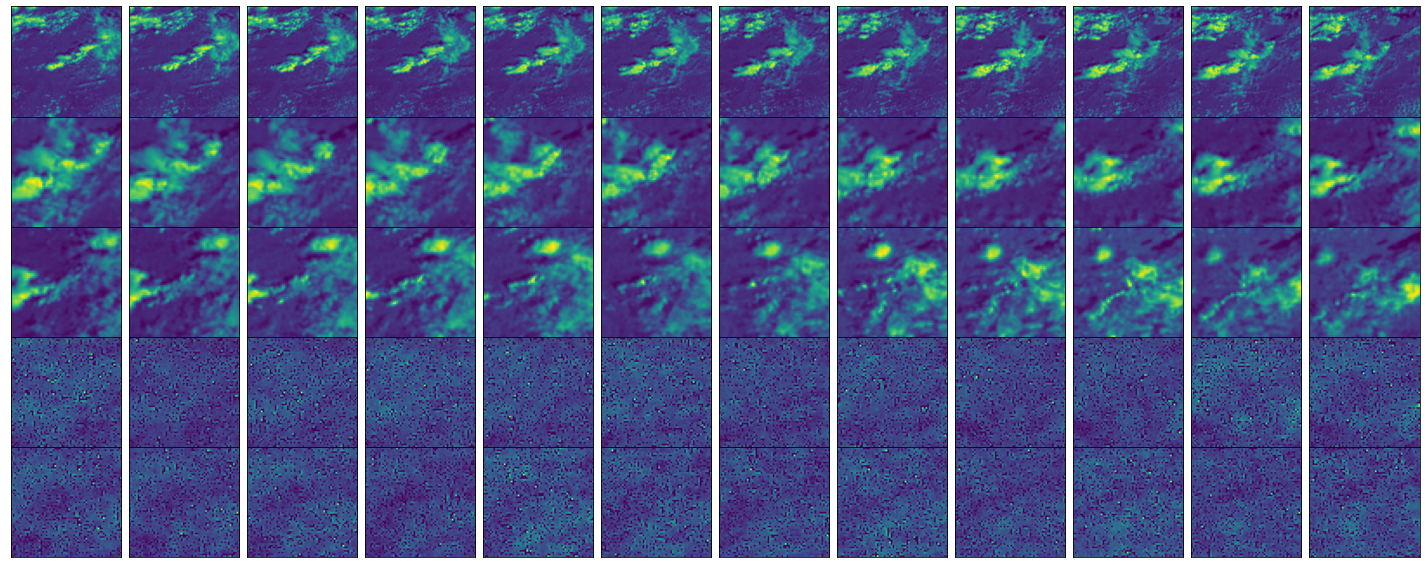

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 12, figsize=(20,8))

# plot the twelve 128x128 input images
for i, img in enumerate(x):
    ax1[i].imshow(img, cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# plot twelve 64x64 true output images
for i, img in enumerate(y[:12]):
    ax2[i].imshow(img, cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 true output images
for i, img in enumerate(y[12:]):
    ax3[i].imshow(img, cmap='viridis')
    ax3[i].get_xaxis().set_visible(False)
    ax3[i].get_yaxis().set_visible(False)

# plot the twelve 64x64 predicted output images
for i, img in enumerate(p[:12]):
    ax4[i].imshow(img, cmap='viridis')
    ax4[i].get_xaxis().set_visible(False)
    ax4[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 output images
for i, img in enumerate(p[12:]):
    ax5[i].imshow(img, cmap='viridis')
    ax5[i].get_xaxis().set_visible(False)
    ax5[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

### Saving the model

Having trained the model, it can now be saved in the `submission` folder so that it may be evaluated on [DOXA](https://climatehack.ai/compete).

In [ ]:
torch.save(model.state_dict(), 'submission/model.pt')

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```